In [ ]:
#@title Run to import libraries
#Install and import libraries
!pip install pyts

import io
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField, MarkovTransitionField
from sklearn.cluster import KMeans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.4 MB/s eta 0:00:00


In [ ]:
#@title Upload Load Data in CSV format
#Upload dataset
from google.colab import files
uploaded = files.upload()

Saving predictors.csv to predictors (1).csv
Saving response.csv to response.csv


In [ ]:
#@title Create train, val and test set
#Create data matrix from dataset
train_data = np.array(pd.read_csv(io.StringIO(uploaded['predictors (1).csv'].decode('utf-8')),index_col=[0]))
label_data = np.array(pd.read_csv(io.StringIO(uploaded['response.csv'].decode('utf-8')),index_col=[0]))
val_data = np.array(pd.read_csv(io.StringIO(uploaded['Panay-2023.csv'].decode('utf-8')),index_col=[0]))
test_data = np.array(pd.read_csv(io.StringIO(uploaded['Panay-2023.csv'].decode('utf-8')),index_col=[0]))

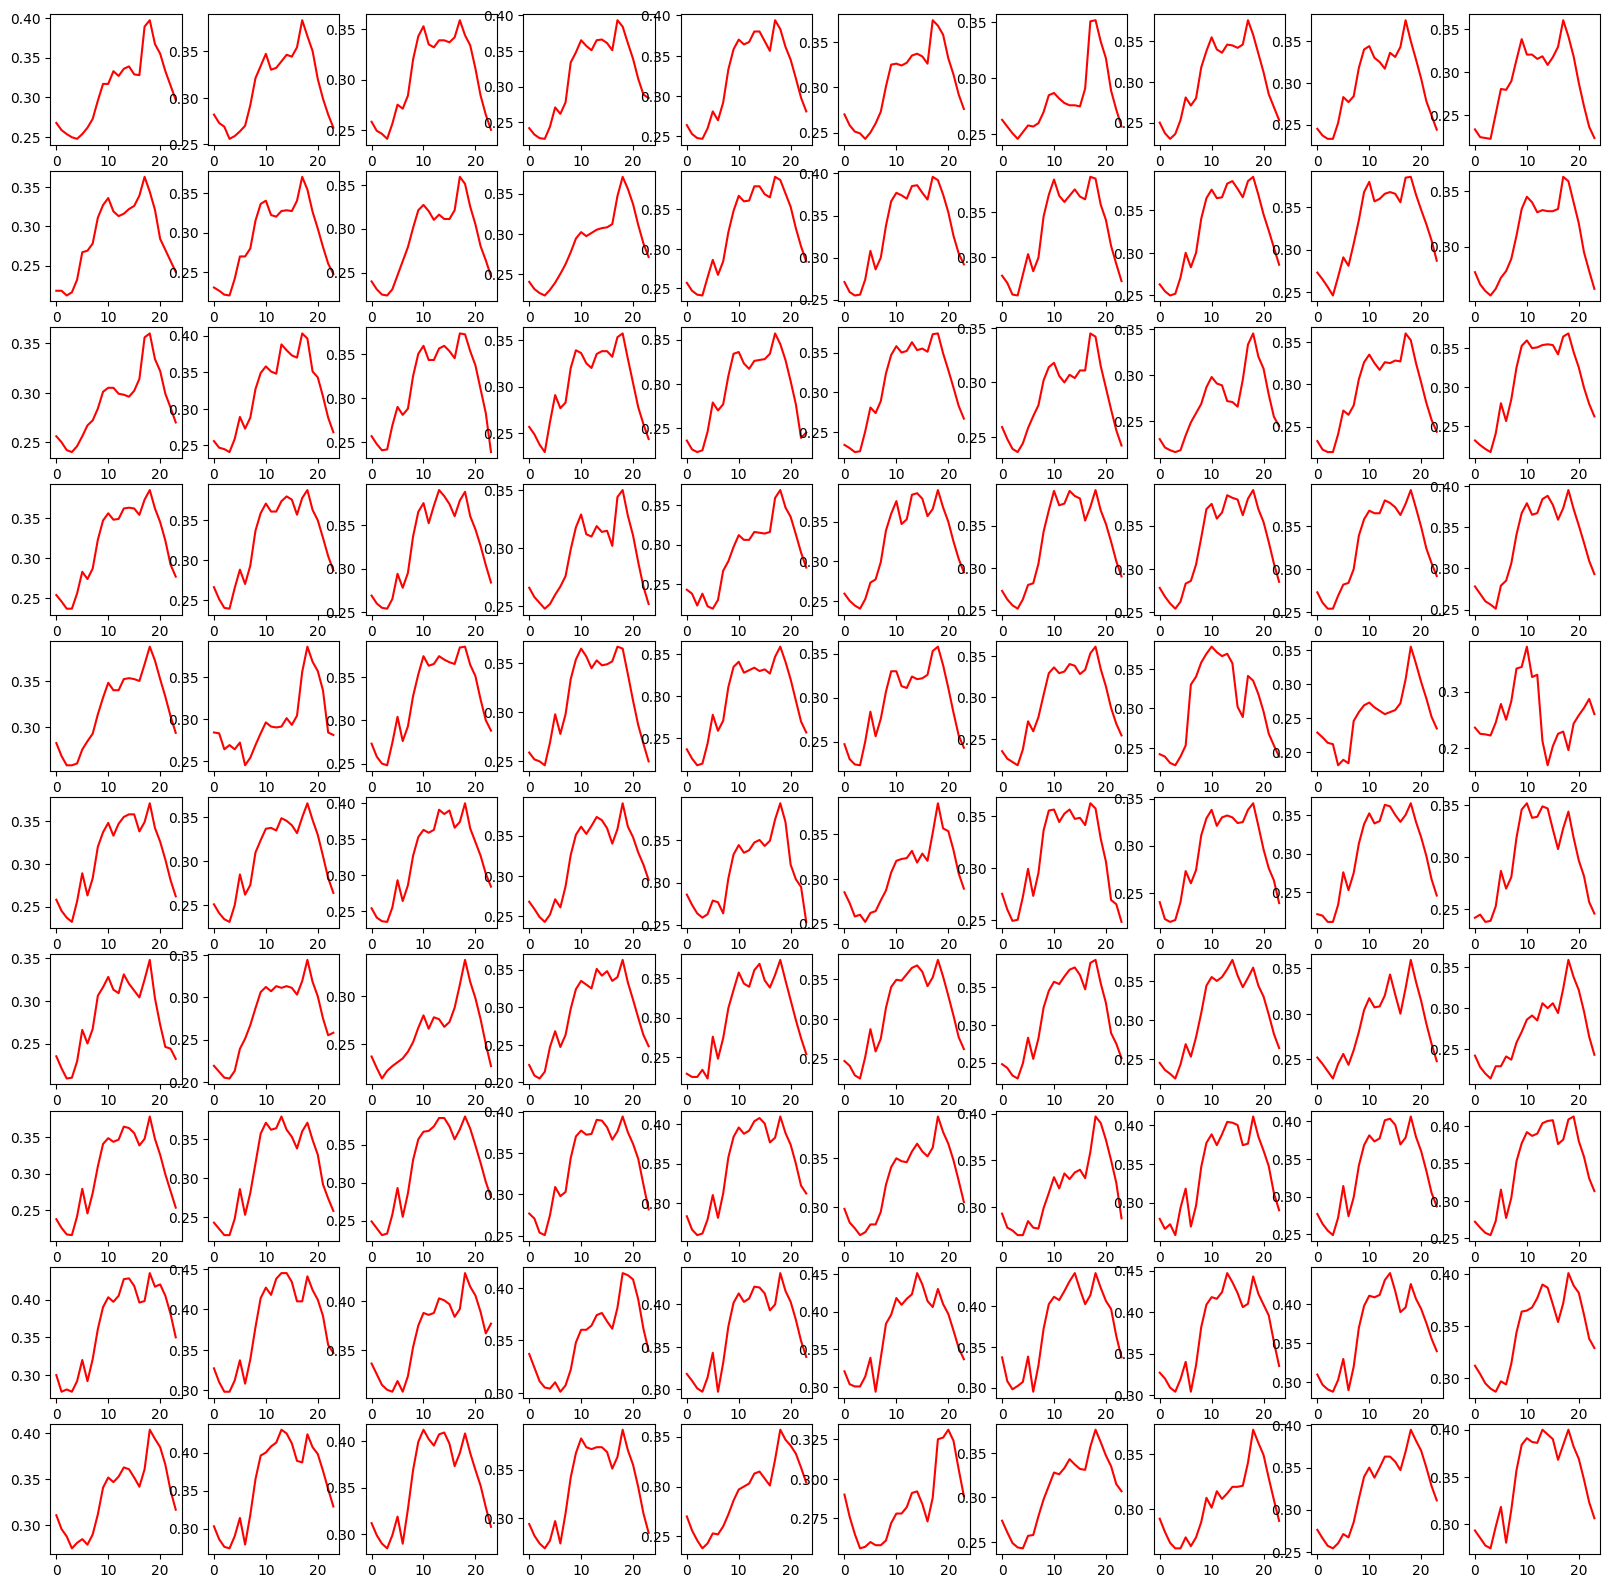

In [ ]:
#@title Plot Original Time Series

#Plotting first 100 samples of the time-series data
w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.plot(train_data[i-1,:].reshape(24,1)/1000, color='red')
plt.show()

In [ ]:
#@title Run to activate imaging algorithm

def image(input_data, image_size):
  W = np.zeros([image_size,image_size]) #Forming the weight matrix
  for i in range(image_size):
    for k in range(image_size):
      W[i,k] = 1- np.abs((i - k)/image_size)

  GAF = []
  for i in range(len(input_data[:,0])):
    gasf = GramianAngularField(image_size, method='summation', sample_range=(-1,1))
    img_gasf = gasf.fit_transform(input_data[i].reshape(1, -1))
    GAF.append(np.ndarray.flatten(np.multiply(W, img_gasf)))

  return(W, GAF)

In [ ]:
#@title Create the modified GAF images

img_train = image(train_data, image_size=24)
img_val = image(val_data, image_size=24)
img_test = image(test_data, image_size=24)


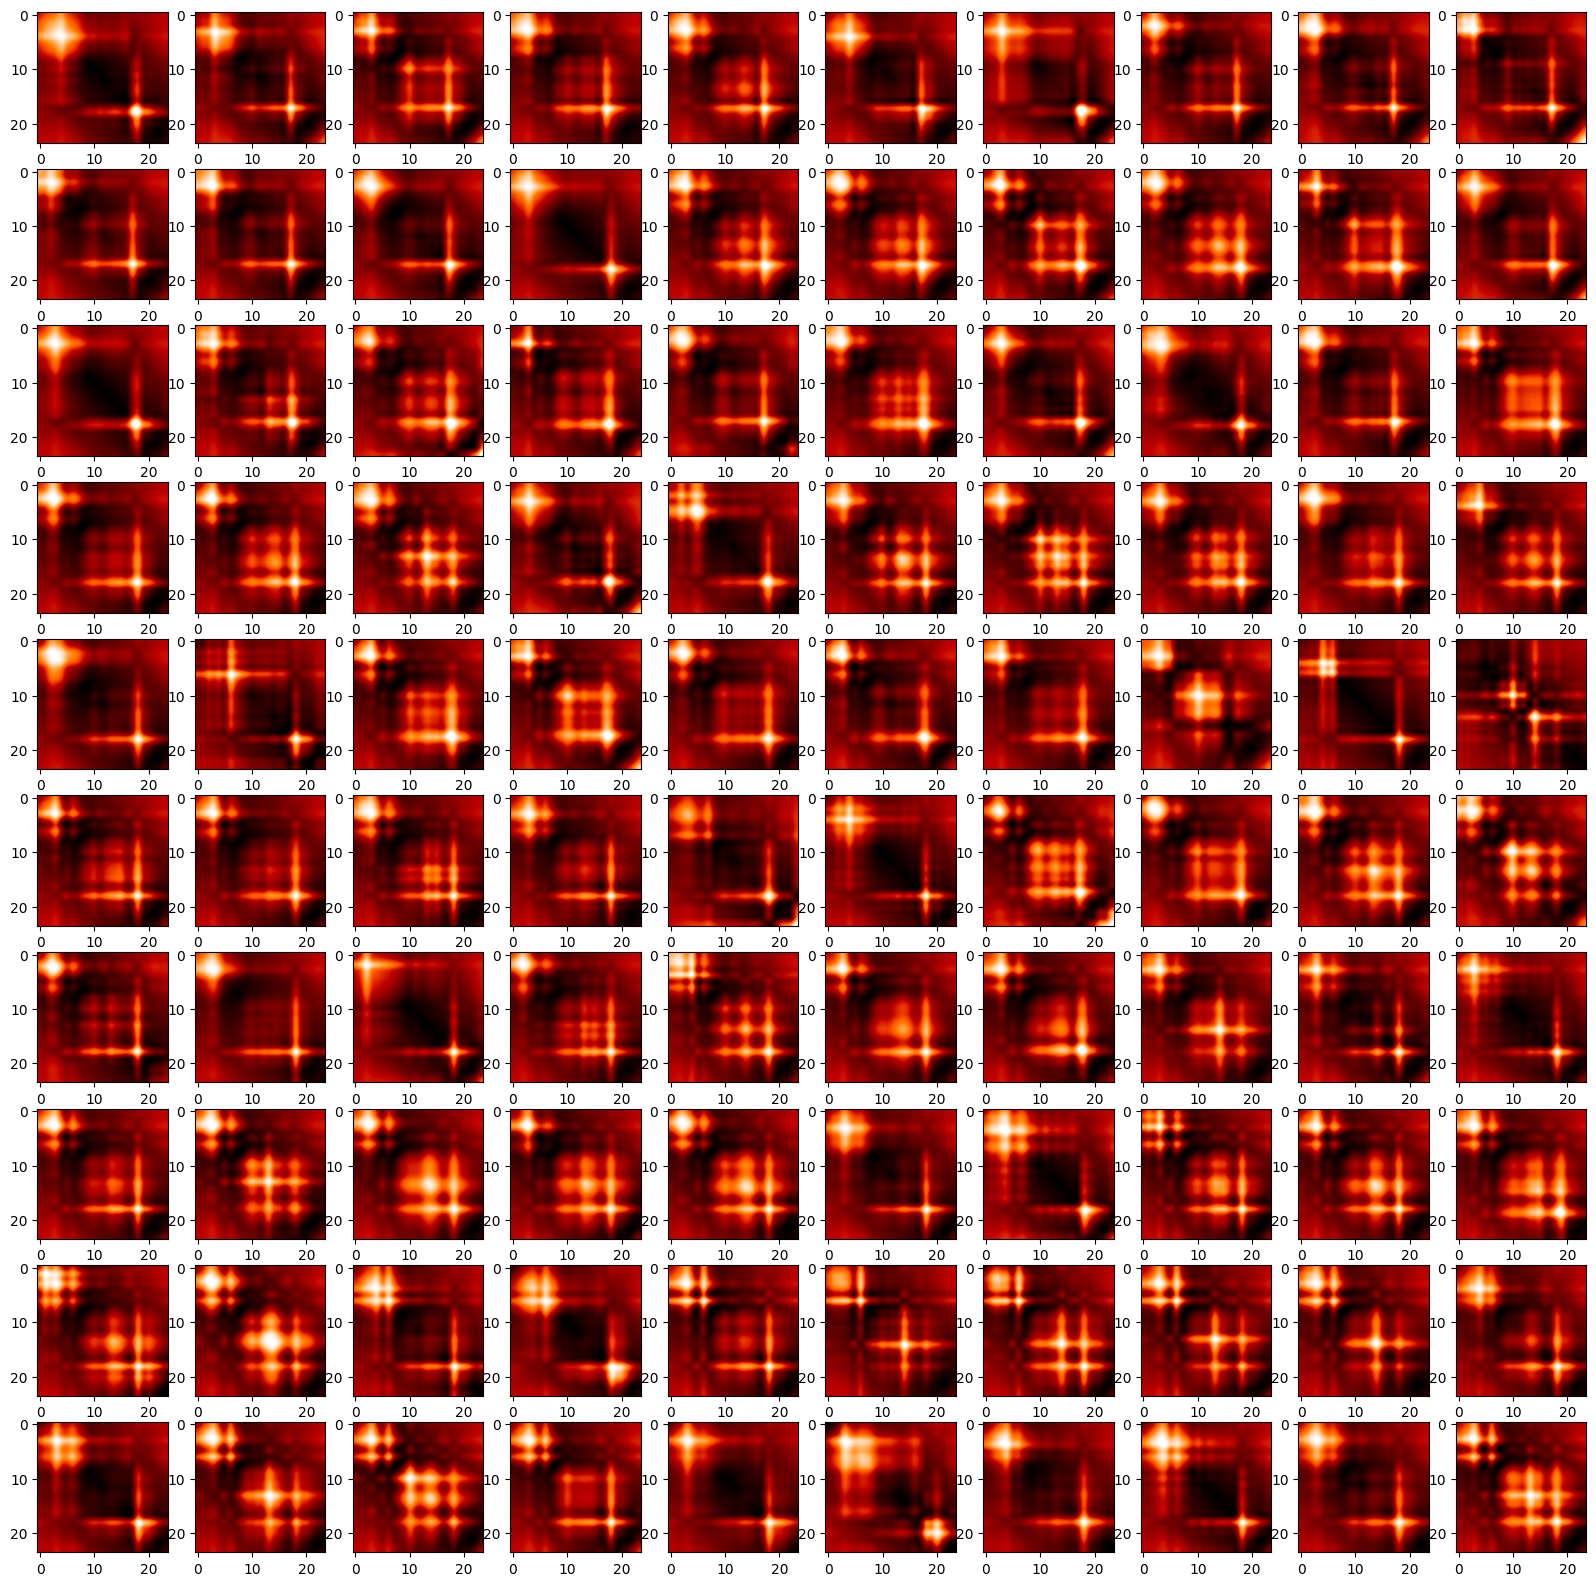

In [ ]:
#@title Visualize the images

#Plotting first 100 samples of the original snapshots
w = 10
h = 10
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.array(img_train[1])[i-1].reshape(24,24), 'gist_heat', interpolation='spline36')
plt.show()


In [ ]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0)
kmeans.fit(np.array(img_train[1]))

# Retrieve the cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

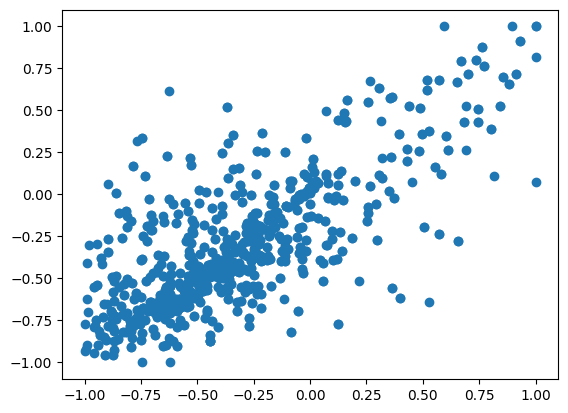

In [ ]:
plt.scatter(img_train[1][0:2], img_train[1][1:3])
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.49153088954173363
For n_clusters = 3 The average silhouette_score is : 0.36815069243428405
For n_clusters = 4 The average silhouette_score is : 0.37033719463464365
For n_clusters = 5 The average silhouette_score is : 0.2687208292631037
For n_clusters = 6 The average silhouette_score is : 0.28120660866787506


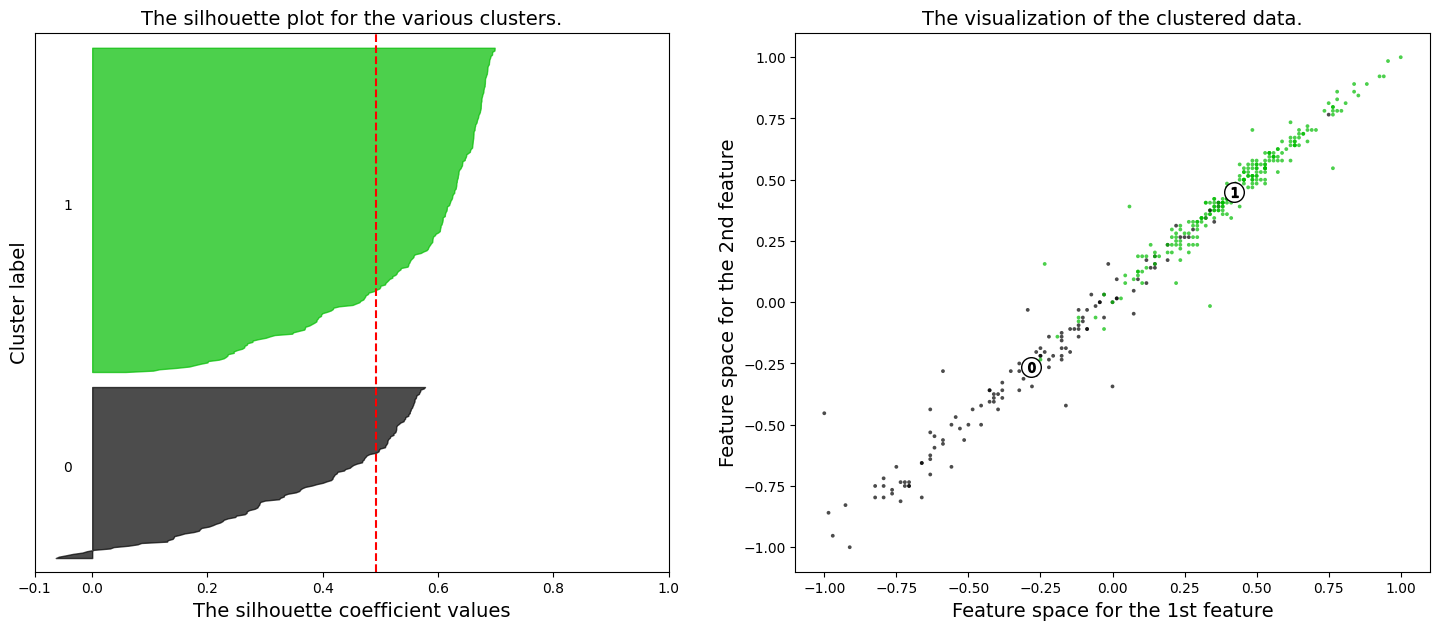

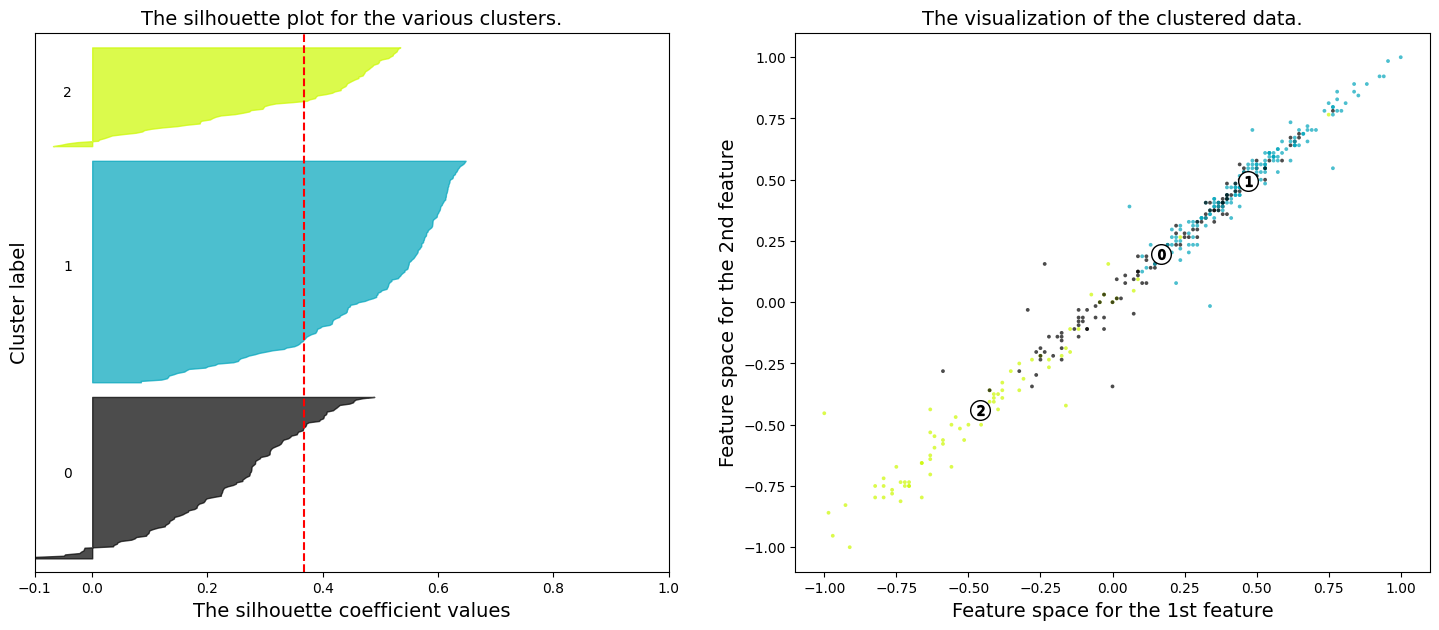

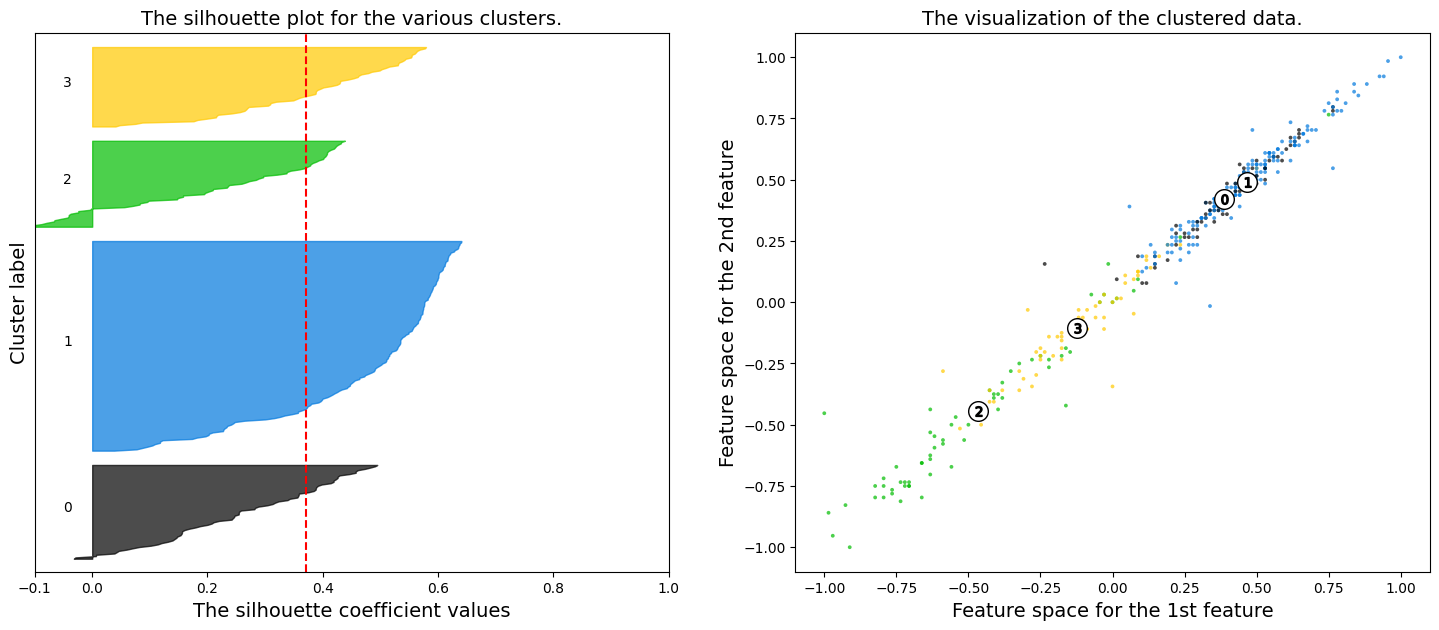

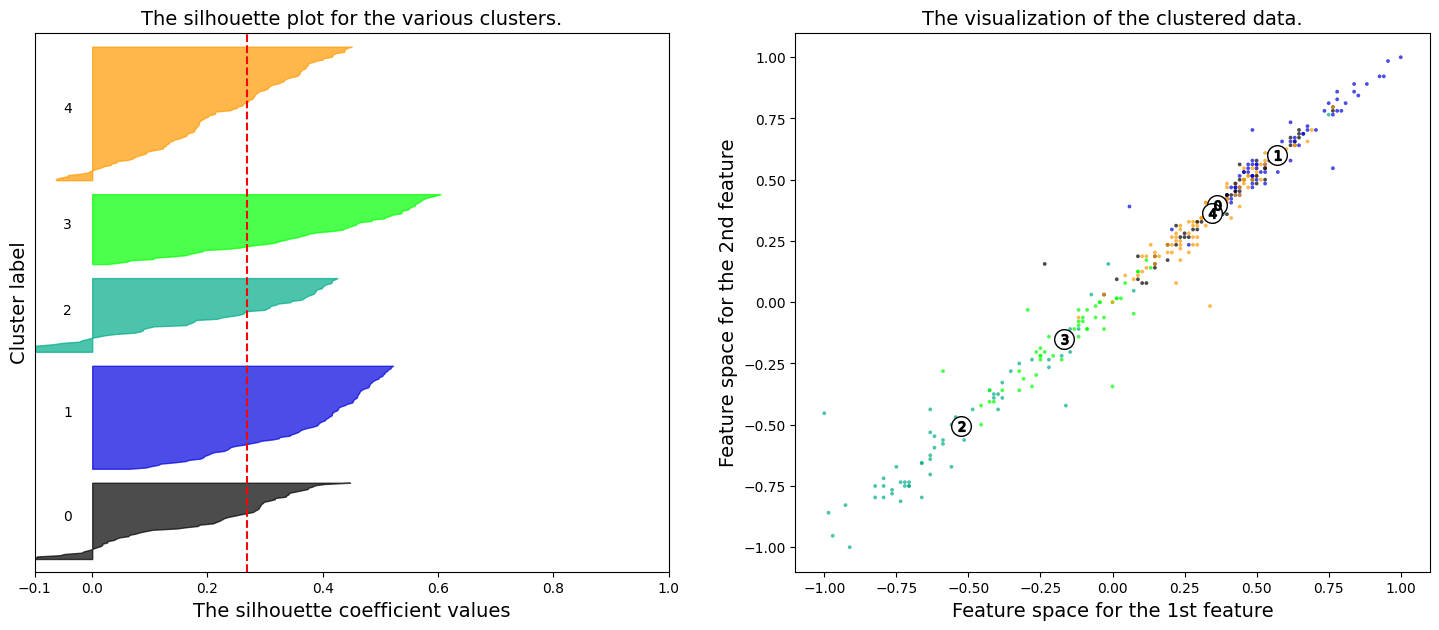

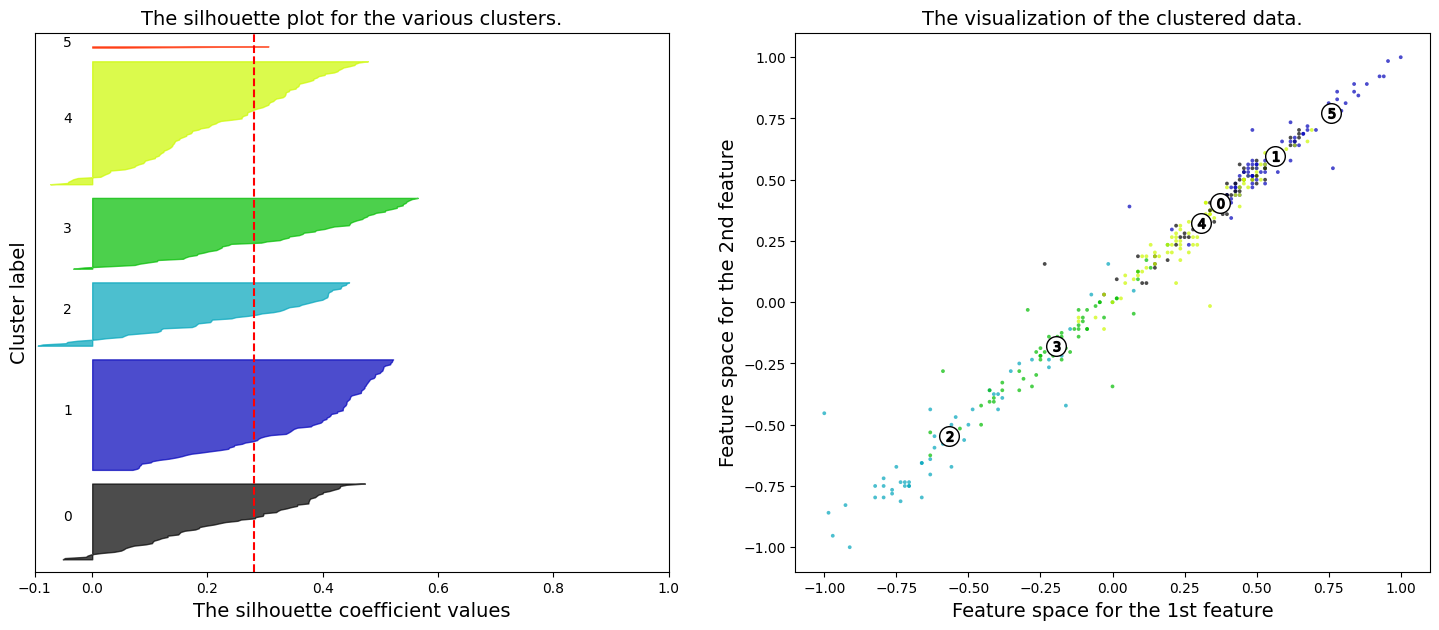

In [ ]:
#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
minmax = MinMaxScaler(feature_range = (-1,1))
X = minmax.fit_transform(train_data) #np.array(img_train[1])
#y = np.array(img_val[1])

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)

    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=14)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=14)
    ax1.set_ylabel("Cluster label", fontsize=14)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.", fontsize=14)
    ax2.set_xlabel("Feature space for the 1st feature", fontsize=14)
    ax2.set_ylabel("Feature space for the 2nd feature", fontsize=14)

    #plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        #% n_clusters,
        #fontsize=14,
        #fontweight="bold",
    #)

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.36770127403929626
For n_clusters = 3 The average silhouette_score is : 0.25652274009100023
For n_clusters = 4 The average silhouette_score is : 0.21759921705768637
For n_clusters = 5 The average silhouette_score is : 0.17290166819532288
For n_clusters = 6 The average silhouette_score is : 0.20532322619251567


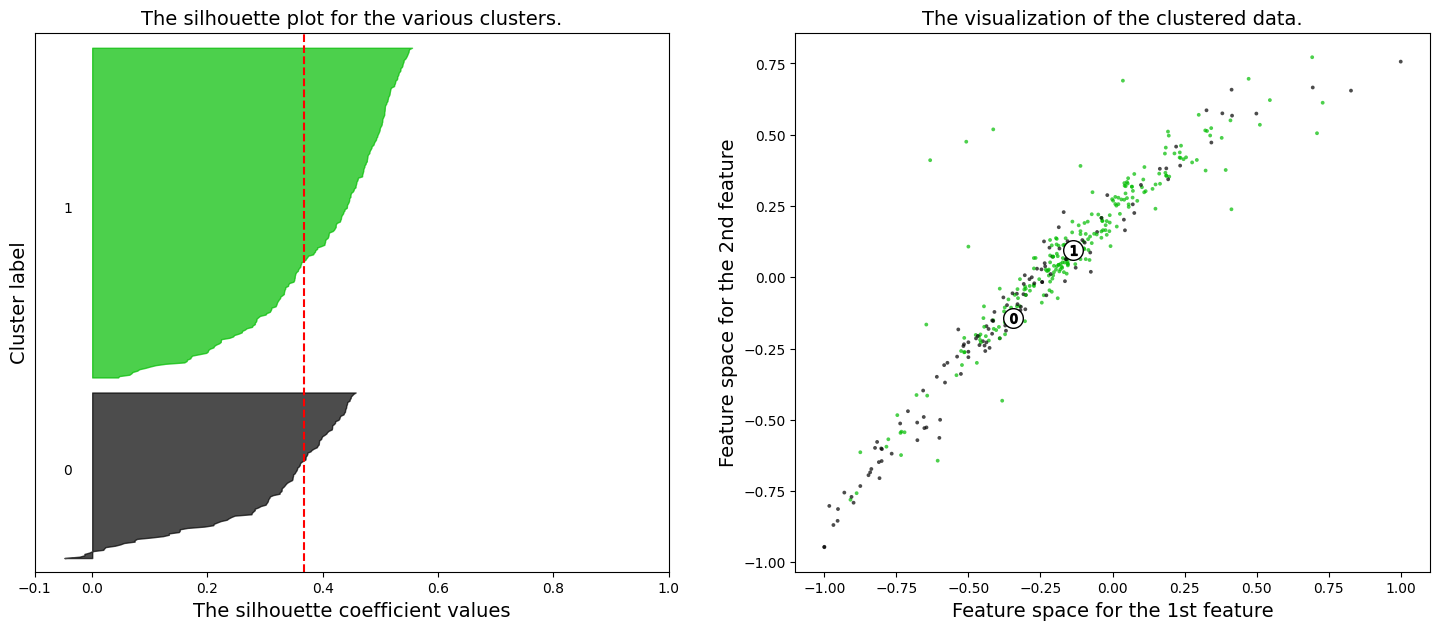

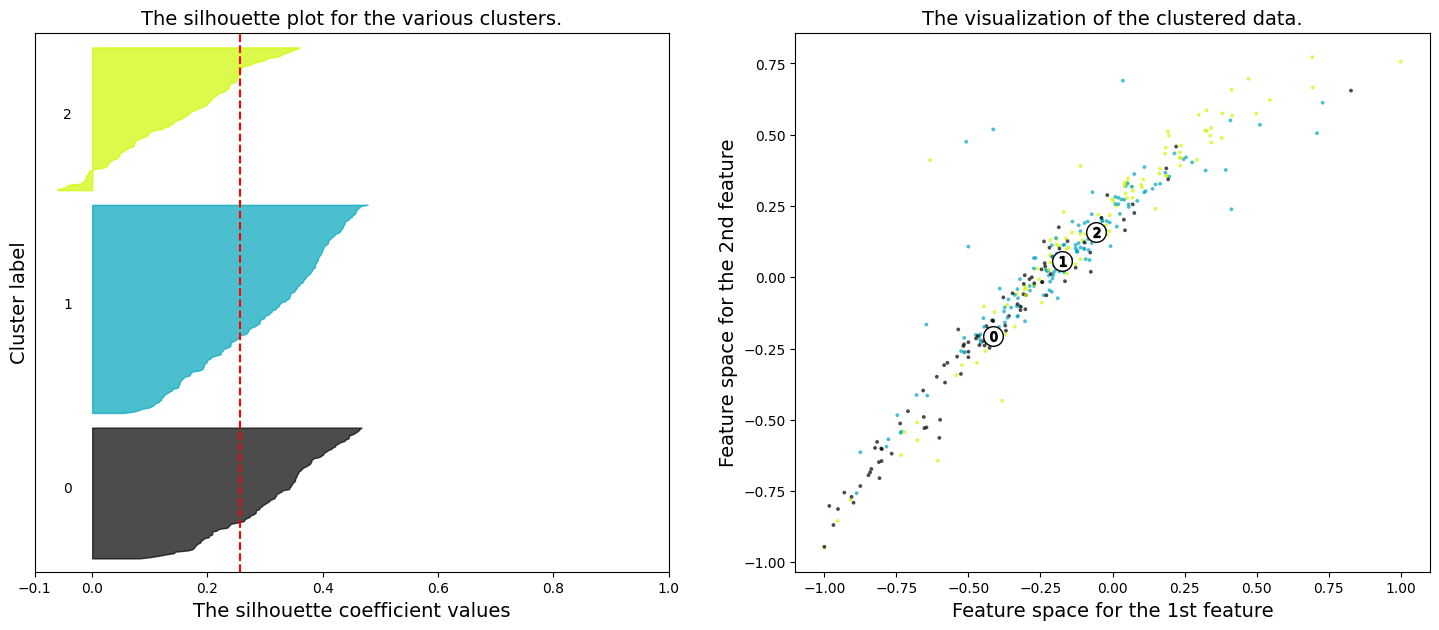

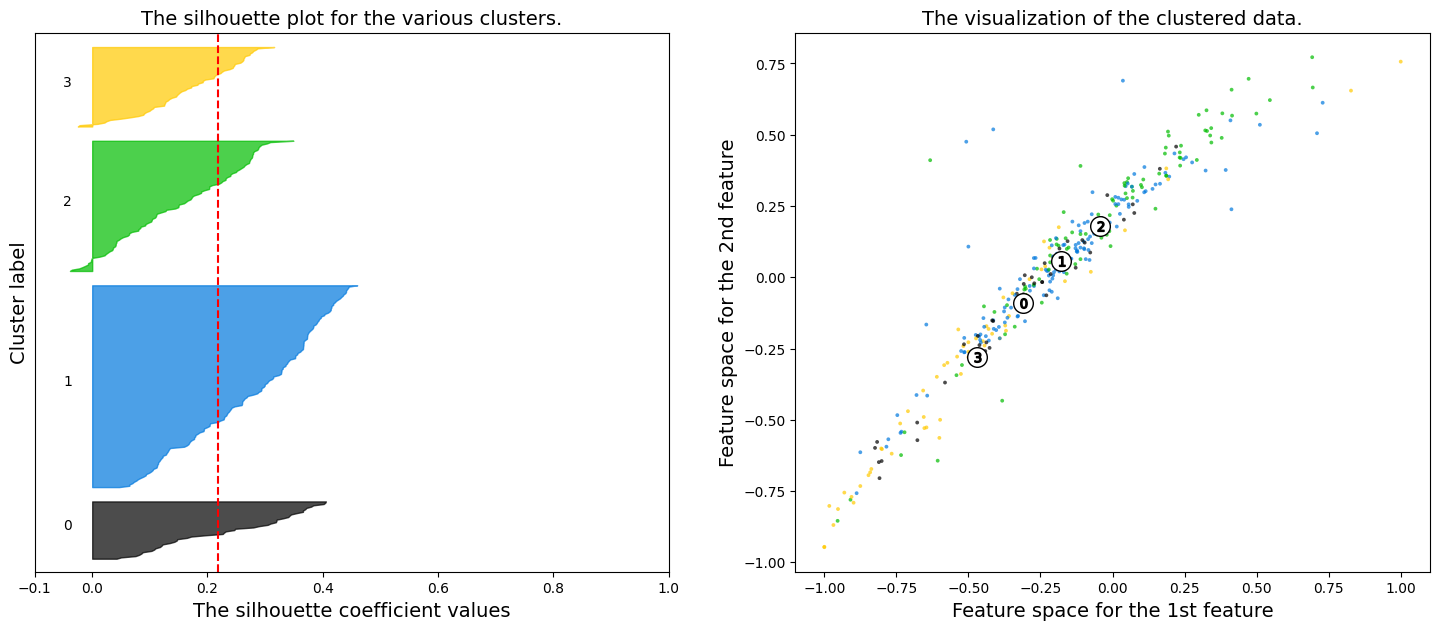

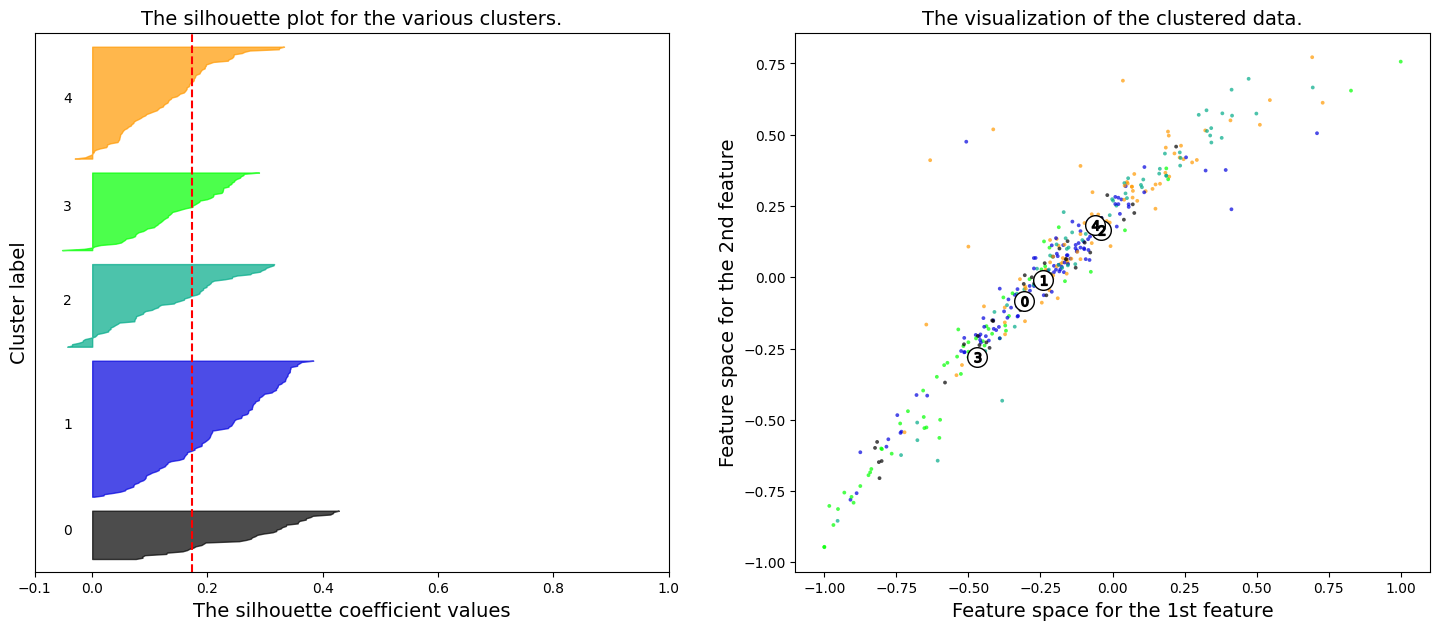

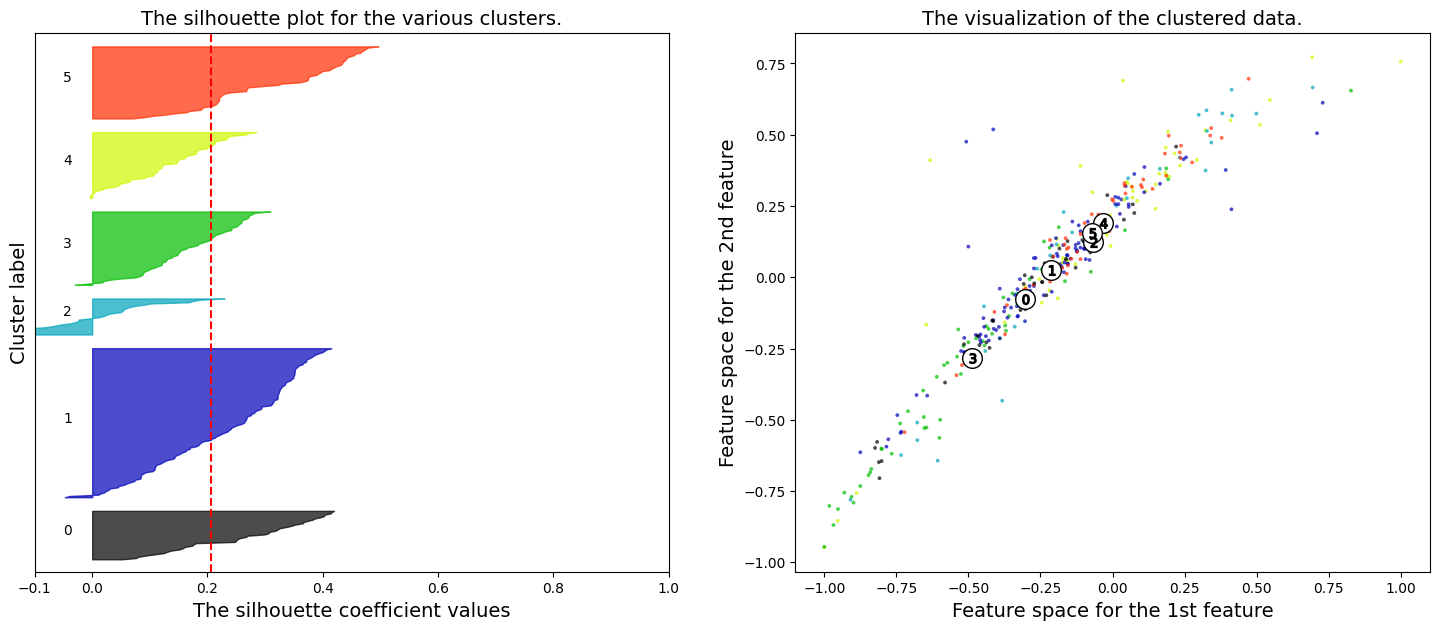

In [ ]:
#from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = np.array(img_train[1])
y = np.array(img_test[1])

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.", fontsize=14)
    ax1.set_xlabel("The silhouette coefficient values", fontsize=14)
    ax1.set_ylabel("Cluster label", fontsize=14)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.", fontsize=14)
    ax2.set_xlabel("Feature space for the 1st feature", fontsize=14)
    ax2.set_ylabel("Feature space for the 2nd feature", fontsize=14)

    #plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        #% n_clusters,
        #fontsize=14,
        #fontweight="bold",
    #)

plt.show()

In [ ]:
#@title Result compiled as exp.zip

pd.DataFrame(np.array(img_train[1]).reshape
             (len(np.array(img_train[1])),1*24*24)).to_csv('img_trn_panay2023.csv')

pd.DataFrame(np.array(img_val[1]).reshape
             (len(np.array(img_val[1])),1*24*24)).to_csv('img_val_panay2023.csv')

pd.DataFrame(np.array(img_test[1]).reshape
             (len(np.array(img_test[1])),1*24*24)).to_csv('img_tst_panay2023.csv')


!zip -r /content/panay2023.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2024.03.26/ (stored 0%)
  adding: content/.config/logs/2024.03.26/13.27.44.510152.log (deflated 58%)
  adding: content/.config/logs/2024.03.26/13.27.27.616697.log (deflated 86%)
  adding: content/.config/logs/2024.03.26/13.27.12.659740.log (deflated 58%)
  adding: content/.config/logs/2024.03.26/13.28.00.408348.log (deflated 57%)